The dataset used for this endeavour was pulled from the University of California Irvine (UCI), and is the product of australian credit card applications, containing 14 features and 1 class label. The dataset can be found here: http://archive.ics.uci.edu/ml/datasets/Statlog+%28Australian+Credit+Approval%29



In [1]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.6 MB/s eta 0:00:00


In [2]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random 

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn import svm
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score,roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, LabelBinarizer
from sklearn.decomposition import PCA

import seaborn as sns

np.random.seed(42)
sns.set_theme(style= "darkgrid")

from google.colab import drive


drive.mount('/content/drive')

path = "/content/australian.dat"


Mounted at /content/drive


In [3]:
# Absence of feature names due to confidentiality make colummn names a tricky task, using basic names to begin
columns = ["Feature 1",
           "Feature 2",
           "Feature 3",
           "Feature 4",
           "Feature 5",
           "Feature 6",
           "Feature 7",
           "Feature 8",
           "Feature 9",
           "Feature 10",
           "Feature 11",
           "Feature 12",
           "Feature 13",
           "Feature 14",
           "Outcome"
           ]
           
df = pd.read_csv(filepath_or_buffer=path, sep=" ", header=None, names=columns)


# Initial glance of dataset
df.head()

# Capturing size of the dataset in terms of rows & columns
print(f"Number of instances: {df.shape[0]}\n")
print(f"Number of features: {df.shape[1] - 1} (excluding class label)\n")

Number of instances: 690

Number of features: 14 (excluding class label)



Given the docs supplied with the link above, we know that the 15th feature is the classification, as 307 datapoints belong to the positive class (44.5%), and 383 (55.5%) belong to the negative class. This is highlighted below:

Given this is a classification problem, we can use the % of the most common class as the baseline model. In this case, judging purely off accuracy, the baseline model yields a 55.5% accuracy.

In [4]:
approvalCount = df['Outcome'].value_counts().get(1, 0)
unapprovedCount = df['Outcome'].value_counts().get(0, 0)

print(f'The number of approved applicants (positive class): {approvalCount}\n')
print(f'The number of unapproved applicants (negative class): {unapprovedCount}\n')
print(f'Ratio : {approvalCount/unapprovedCount:.2f}')
print(f'Baseline model accuracy: {(unapprovedCount/df.shape[0]) *100:.2f}%')


The number of approved applicants (positive class): 307

The number of unapproved applicants (negative class): 383

Ratio : 0.80
Baseline model accuracy: 55.51%


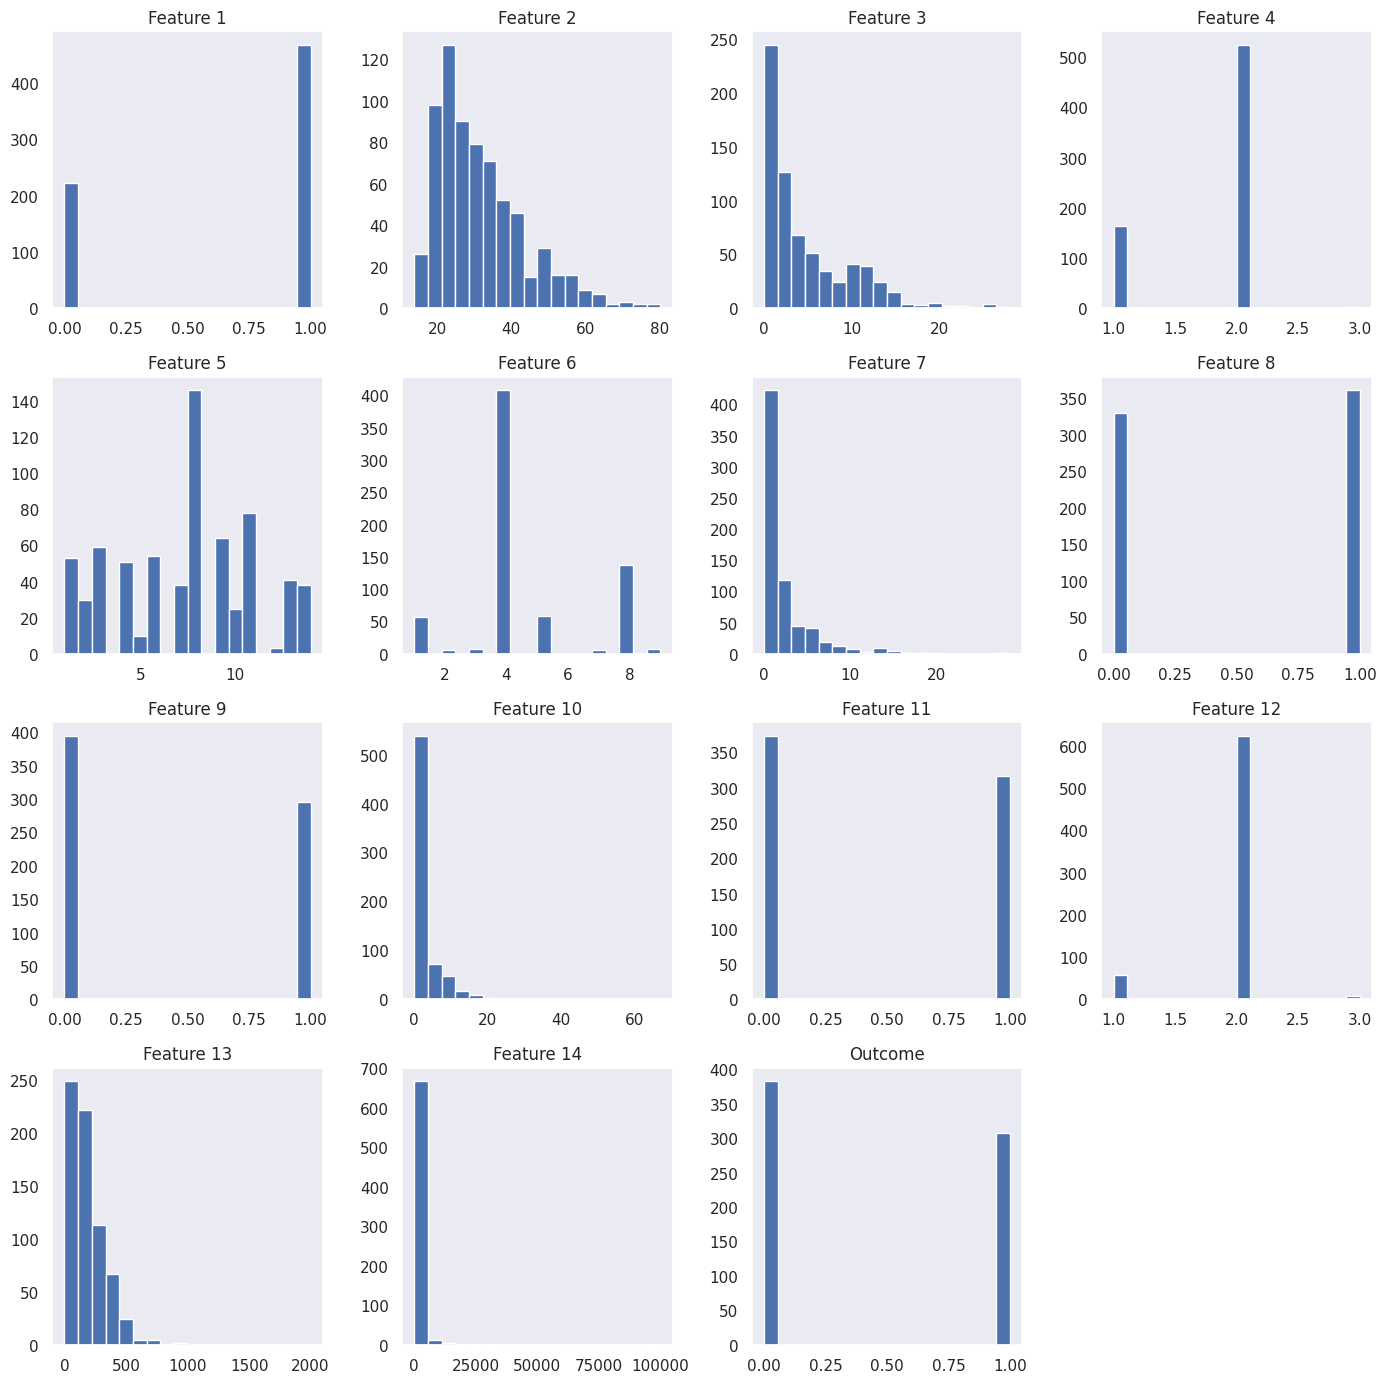

In [5]:
# With the columns now labelled, and data successfully loaded into a pandas format, it is time for EDA and basic analysis

# Histograms of each feature
df.hist(figsize=(14, 14), bins=18, grid=False)
plt.tight_layout()
plt.show()


**At first glance:**

*   The histograms clearly detail how the dataset is structured from the perspective of each column.
*   Some features are in a binary format (0 or 1)
and others take continous values. 
*   The binary values clearly do not express any concern, however some continous columns such as feature 2 and 3 are clearly quite skewed in their distribution (positively). Prompting investigation.




**Outlier Removal**

*   Given the features are not provided due to confidentiality, it is difficult to investigate features like 2 and 3, and determine what would constitute as an outlier in this sense. 
*   While there appears to be points in the historgrams that may strike as outliers, first we must investigate the features the best we can, and then draw conclusions on what values may be recognised as outliers.






In [6]:
# Considering the fact that the features themselves are not known, and it is difficult to infer what they are due to the nature of credit applications
# Outside of a few expected features(i.e. credit score, which when looking at the histograms we can make an educated guess that credit score is feature 13)

# The next logical step is to get a feel for each of the features besides the outcome

exclude = "Outcome"
df_without_outcome = df.drop(columns=exclude)
metricAnalysis = df_without_outcome.describe()

metricAnalysis


,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,Feature 11,Feature 12,Feature 13,Feature 14
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000,690.000000,690.000000
mean,0.678261,31.568203,4.758725,1.766667,7.372464,4.692754,2.223406,0.523188,0.427536,2.40000,0.457971,1.928986,184.014493,1018.385507
std,0.467482,11.853273,4.978163,0.430063,3.683265,1.992316,3.346513,0.499824,0.495080,4.86294,0.498592,0.298813,172.159274,5210.102598
min,0.000000,13.750000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000
25%,0.000000,22.670000,1.000000,2.000000,4.000000,4.000000,0.165000,0.000000,0.000000,0.00000,0.000000,2.000000,80.000000,1.000000
50%,1.000000,28.625000,2.750000,2.000000,8.000000,4.000000,1.000000,1.000000,0.000000,0.00000,0.000000,2.000000,160.000000,6.000000
75%,1.000000,37.707500,7.207500,2.000000,10.000000,5.000000,2.625000,1.000000,1.000000,3.00000,1.000000,2.000000,272.000000,396.500000
max,1.000000,80.250000,28.000000,3.000000,14.000000,9.000000,28.500000,1.000000,1.000000,67.00000,1.000000,3.000000,2000.000000,100001.000000


As we can see above, it appears all columns hold the 690 values, meaning that initially we will not be required to remove any data from said columns. This may change with further preprocessing.



Now that we have an initial view of the values, before we worry about removal of potential outliers, it makes sense to develop a correlation matrix, and view if any of the features are correlated.

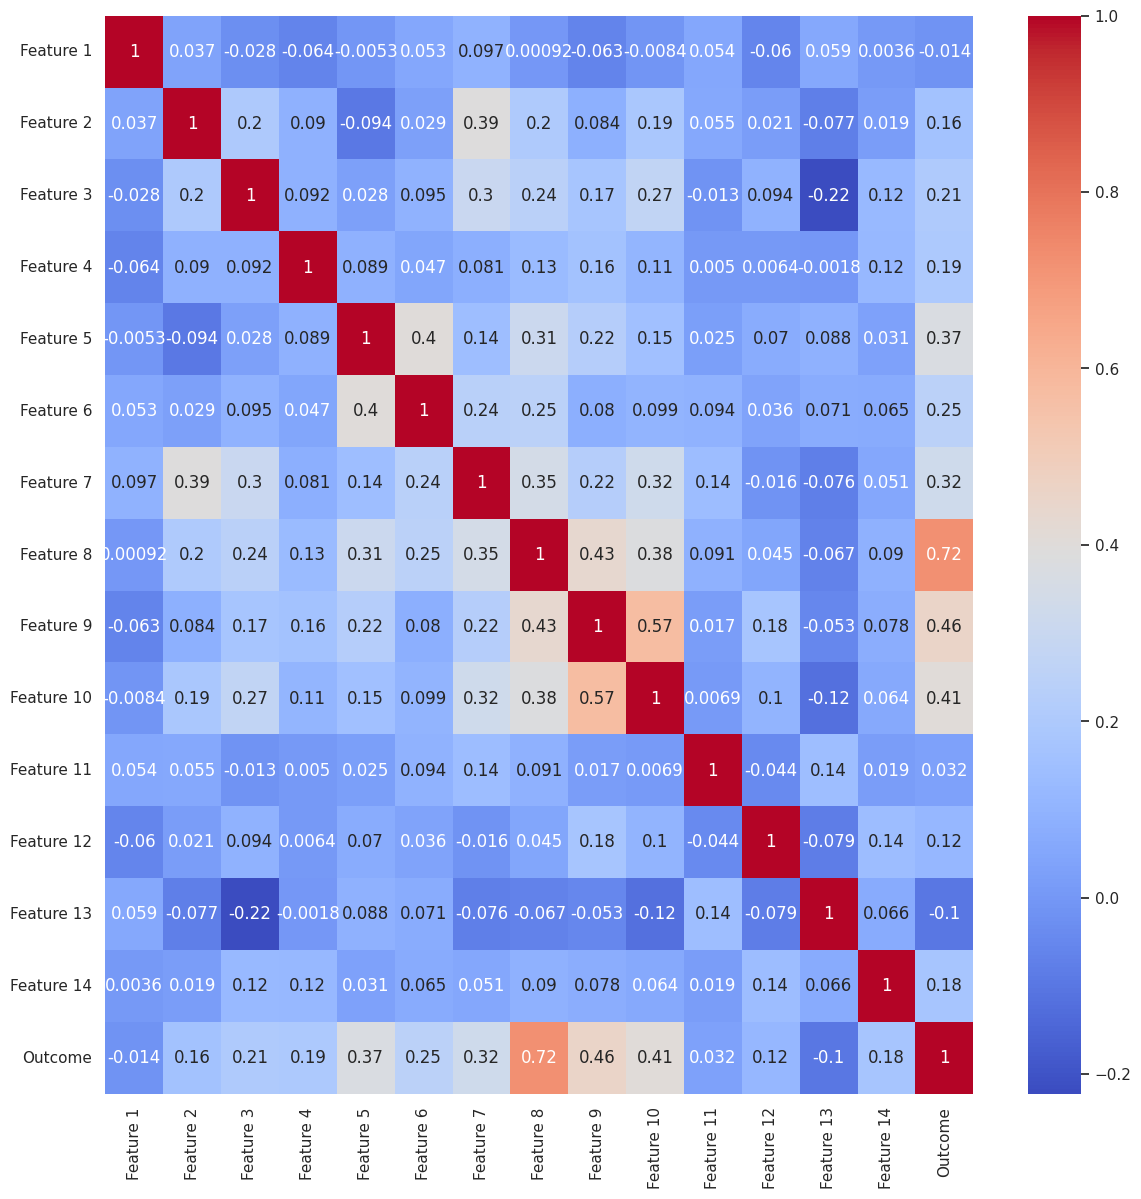

In [7]:
# Creating correlation matrix
corrMatrix = df.corr()
fig, ax = plt.subplots(figsize=(14,14)) 
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm', ax=ax)
plt.show()


Observing the heatmap above, it appears that feature 8 could be considered as highly correlated with the outcome of a credit application. 

Besides this relation, it appears the threat of multicolinearity is low, and is something we do not have to worry about further.

Time to investigate feature selction further, let's examine the feature importance:


The feature importance of this model:  [0.01082523 0.07264224 0.07920662 0.01583898 0.07087907 0.02897095
 0.09837918 0.30003048 0.05401229 0.10501622 0.01070899 0.01329562
 0.06789047 0.07230366]


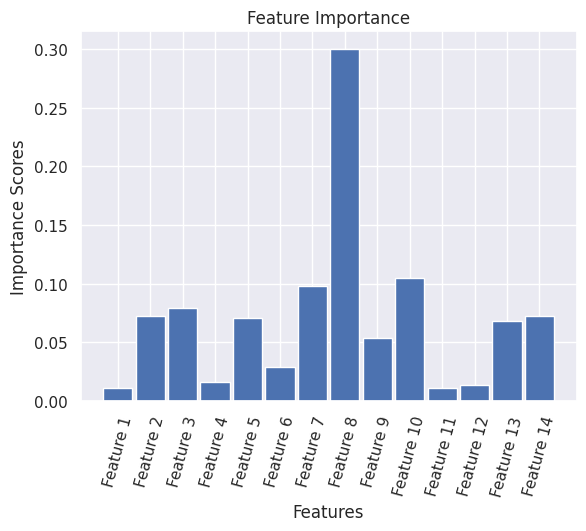

In [8]:
# Feature importance using a tree model

rf = RandomForestClassifier()

X = df.drop(columns="Outcome")
y = df["Outcome"]


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

rf.fit(X_scaled, y)

feature_importance = rf.feature_importances_

print("The feature importance of this model: ", feature_importance)

feature_names = X.columns.tolist()

plt.bar(feature_names,feature_importance, width=0.9)
plt.xlabel('Features')
plt.ylabel('Importance Scores')
plt.title('Feature Importance')
plt.xticks(rotation=75)
plt.show()

Seems like feature 8 is indeed a very important feature of this model, with features 1,11,and 12 being very low in terms of importance. It may be worthwhile exploring the removal of said features, and see how this impacts our performance.

Additionally, we can see feature 9 and 10 having a moderately high correlation between eachother, it may be worthwhile to either combine these features, or remove them, to aid in model performance.

Previous efforts at feature engineering for this problem found transforming continuous features, and dropping irrelevant ones did little to aid in performance of the model. This time, I will attempt PCA to aid model performance

In [9]:
# Performing PCA

pca = PCA()
pca.fit(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

threshold = 0.99

# Find the number of components that meet the threshold
optimal_pca_count = np.where(cumulative_explained_variance >= threshold)[0][0] + 1

print(f"The optimal PCA count is: {optimal_pca_count}")

The optimal PCA count is: 11


I want to keep as much of the variance as possible to improve predictive power, this dataset is relatively small as is, and coupled with the fact I'm doing this via colab, I want to maximise the predictive power of my models.


In [10]:
pca = PCA(n_components=optimal_pca_count)

newFeatures = pca.fit_transform(X_scaled)

principalDf = pd.DataFrame(data = newFeatures
             , columns = ['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7','PC8','PC9','PC10','PC11',])

df = pd.concat([principalDf, df[['Outcome']]], axis = 1)

print(f'The explained variance ratio: {pca.explained_variance_ratio_}')

df.head()

The explained variance ratio: [0.30069611 0.20161937 0.16835532 0.11266657 0.06744799 0.03646273
 0.03402068 0.02541274 0.01996215 0.01665276 0.00696376]


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,Outcome
0,-0.611193,-0.676453,0.022281,0.178781,0.102119,0.202704,0.026092,0.060198,0.323113,-0.009905,0.008609,0
1,-0.682340,0.619751,0.493718,-0.117165,-0.168175,0.095473,0.117277,0.067268,0.137467,-0.001406,0.007061,0
2,-0.624717,-0.289894,0.911192,0.038775,0.092997,-0.260247,-0.247627,0.019451,-0.041263,0.049992,0.024779,0
3,0.747381,-0.075469,0.777760,0.148933,0.384949,-0.410255,-0.200051,0.079634,0.273045,-0.064741,-0.056524,1
4,0.608021,0.401144,-0.535574,0.152234,0.235220,0.000502,0.072891,-0.124643,0.214880,-0.022309,0.029012,1


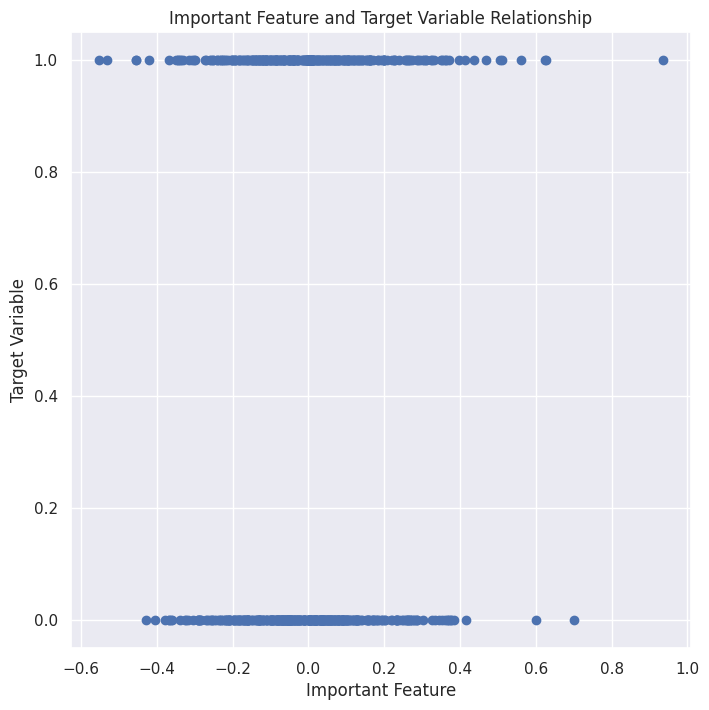

In [ ]:
# Let's investigate the mystery feature 8, and it's relation to the outcome of an application

plt.figure(figsize=(8,8))
plt.scatter(df['PC8'], df['Outcome'])
plt.xlabel('Important Feature')
plt.ylabel('Target Variable')
plt.title('Important Feature and Target Variable Relationship')
plt.show()

It appears from first glance that feature 8 will play an important role in the performance of the model. Thankfully, feature 8 does not appear to have high correlation with any other features present, so no need to worry about dealing with such issues.


Now is the time to apply a classification model, as this model yields a binary output. To start I will use logistic regression as my baseline model.

In [ ]:
X = df.drop(columns="Outcome")
y = df["Outcome"]

# Given that a good portion of the features are binary, and most of the continuous ones are positively skewed, it makes
# sense in this regard to apply minmax scaling


logRegression = LogisticRegression()

crossValidation = cross_val_score(logRegression, X_scaled, y, cv=5, scoring='accuracy',)

print(f"Cross-validation scores for logistic regression: {crossValidation}")
print(f"Accuracy of Model with Cross Validation is: {crossValidation.mean() * 100:.2f}%")

Cross-validation scores for logistic regression: [0.9057971  0.80434783 0.86956522 0.82608696 0.89130435]
Accuracy of Model with Cross Validation is: 85.94%


As witnessed above, the results are already fairly respectable, and all above 0.8 for now with just a simple logistic regression model.

Now to test for the random forest classifier

In [ ]:
# For now, let's just apply a base random forest classifier, I'll look into hyperparameter tuning shortly
rfClassifier = RandomForestClassifier()

crossValidationRF = cross_val_score(rfClassifier, X_scaled, y, cv=5, scoring="accuracy")


print(f"Cross-validation scores for random forest: {crossValidationRF}")
print(f"Accuracy of Model with Cross Validation is: {crossValidationRF.mean() * 100:.2f}%")

Cross-validation scores for random forest: [0.89130435 0.8115942  0.89130435 0.81884058 0.86231884]
Accuracy of Model with Cross Validation is: 85.51%


As we can see, fairly similar between the two initially.

Considering the results, I have decided to now perform a grid paramater search for both models, and see which performs better after hyperparameter tuning.

I have previously attempted this with random search, however improvements were negligible at best.

In [ ]:
# First, lets tune logistic regression with grid search

logRegGrid = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l2'], 
    'solver': ['saga','lbfgs'],
    'max_iter': [100, 200, 500, 1000], 
}

logRegression = LogisticRegression()

grid_search_logreg = GridSearchCV(
    logRegression, logRegGrid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_logreg.fit(X_scaled, y)

print(f"Best parameters for logistic regression: {grid_search_logreg.best_params_}" )
print(f"Best score for logistic regression with grid search: {grid_search_logreg.best_score_*100:.2f}%" )

Best parameters for logistic regression: {'C': 0.08858667904100823, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Best score for logistic regression with grid search: 86.67%


In [ ]:
rfGrid = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': list(range(1, 21)), 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4, 6], 
    'max_features': ['sqrt', 'log2'], 
}

rfClassifier = RandomForestClassifier()

grid_search_rf = GridSearchCV(
    rfClassifier, rfGrid, cv=5, scoring='accuracy', n_jobs=-1,)

grid_search_rf.fit(X_scaled, y)

print(f"Best parameters for random forest classifier: {grid_search_rf.best_params_}")
print(f"Best score for random forest classifier with grid search: {grid_search_rf.best_score_*100:.2f}%")

Best parameters for random forest classifier: {'max_depth': 13, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 10}
Best score for random forest classifier with grid search: 88.12%


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Unfortunately, after multiple rounds of feature engineering, and changes to parameter tuning (Grid and random search), there is little improvement. Nonetheless, let's apply bayesian optimisation and see if this can improve the models by a greater extent. If not, I will apply bayesian optimisation to an xgboost and svm model.

In [ ]:
 # Now is the time to test an alternative hyperparameter optimiser, bayesian optimisation

param_space_logreg = {
    'C': (1e-6, 1e+6, 'log-uniform'), # Inverse regularization strength
    'penalty': ['l2'], # Penalty type
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga'], # Optimization algorithm
    'max_iter': (100, 1000), # Maximum number of iterations
}

# Define the search space for random forest classifier
param_space_rf = {
    'n_estimators': (10, 500), # Number of trees in the forest
    'max_depth': (1, 20), # Maximum depth of the tree
    'min_samples_split': (2, 10), # Minimum number of samples required to split an internal node
    'min_samples_leaf': (1, 4), # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'], # Number of features to consider when looking for the best split
}

# Create the models
logreg = LogisticRegression()
rf = RandomForestClassifier()

# Perform Bayesian optimization with cross-validation (e.g., 5-fold CV)
bayes_search_logreg = BayesSearchCV(logreg, param_space_logreg, n_iter=150, cv=5, n_jobs=-1, random_state=42)
bayes_search_rf = BayesSearchCV(rf, param_space_rf, n_iter=150, cv=5, n_jobs=-1, random_state=42)

# Fit the models
bayes_search_logreg.fit(X_scaled, y)
bayes_search_rf.fit(X_scaled, y)

# Print the best parameters and score
print(f"Best parameters for logistic regression: {bayes_search_logreg.best_params_}")
print(f"Best score for logistic regression: {bayes_search_logreg.best_score_*100:.2f}%")
print(f"Best parameters for random forest classifier: {bayes_search_rf.best_params_}") 
print(f"Best score for random forest classifier: {bayes_search_rf.best_score_*100:.2f}%")

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

Best parameters for logistic regression: OrderedDict([('C', 1125.0852631170942), ('max_iter', 1000), ('penalty', 'l2'), ('solver', 'lbfgs')])
Best score for logistic regression: 86.67%
Best parameters for random forest classifier: OrderedDict([('max_depth', 9), ('max_features', 'auto'), ('min_samples_leaf', 1), ('min_samples_split', 10), ('n_estimators', 16)])
Best score for random forest classifier: 87.68%


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Ever so slightly better performance from the bayesian optimisation technique. With this in mind, I will now use an XGBoost model with bayesian optimisation

In [ ]:
param_grid_xgb = {
    'learning_rate': np.linspace(0.1, 0.8, 15),
    'gamma': np.linspace(0, 1, 11),
    'max_depth': [2, 3, 4, 5, 6,], 
    'min_child_weight': [1, 2, 3, 5], # Controls the minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # Subsampling ratio of the training instances
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # Ratio of columns (features) to sample
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'objective': ['binary:logistic'], # For binary classification problem
    # For multi-class classification problem, you can use 'multi:softmax' or 'multi:softprob'
    # and also provide 'num_class' parameter with the number of classes
}

xgBoost = xgb.XGBClassifier()

bayes_search_xgb = BayesSearchCV(xgBoost, param_grid_xgb, n_iter=150, cv=10, n_jobs=-1, random_state=42)

bayes_search_xgb.fit(X_scaled, y)


# Print the best parameters and score
print("Best parameters for XGBoost:", bayes_search_xgb.best_params_)
print("Best score for XGBoost with bayesian optimisation:", bayes_search_xgb.best_score_)

[18:02:50] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[18:02:50] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[18:02:50] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[18:02:50] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[18:02:50] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[18:02:50] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[18:02:50] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[18:02:50] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[18:02:50] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 2 pruned nodes, max_

In [ ]:
# Let's also try a support vector machine model:

# The two most important factors of the support vector machine in terms of parameters, is the C and Gamma.

# RBF kernel will be used, due to it's performance in defining class boundaries in multi-dimensional space at
# the cost of computation

param_grid_svm = {
  'C': np.logspace(-2, 10, 13),
  'gamma': np.logspace(-9, 3, 13),
}

supportVector = svm.SVC(kernel='rbf')

bayes_search_sv = BayesSearchCV(supportVector, param_grid_svm, n_iter=150, cv=10, n_jobs=-1, random_state=42)

bayes_search_sv.fit(X_scaled, y)

# Print the best parameters and score
print("Best parameters for logistic regression:", bayes_search_sv.best_params_)
print("Best score for logistic regression:", bayes_search_sv.best_score_*100)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

Best parameters for logistic regression: OrderedDict([('C', 100000000.0), ('gamma', 0.0001)])
Best score for logistic regression: 86.81159420289856


Unfortunately, despite an hour of run time, still only around 87%. 


Despite multiple changes to the feature engineering, including the use of PCA, dropping irrelevant features, and even transformation using yao johnson, the changes to the scores were not noteworthy.

It appears that given the limited volume of data, the models have reached their maximum performance on this dataset, which could make sense as this dataset was largely preprocessed beforehand by the folks at UCI.

Furthermore, the unknown nature of the features makes this a difficult topic to explore further, whilst some may be able to be deduced (for instance credit score), other features are simply not that easy to deduce, and it is not guaranteed further knowledge of said features will lead to any breakthroughs in the feature engineering process/model selection.

The next logical step, is to investigate the results of the models with the optimal hyperparameters further. Judging solely on the basis of accuracy is not the most effective measure of the models, and especially in this case given the very similar performance across the board, which is evidenced in the graph below.


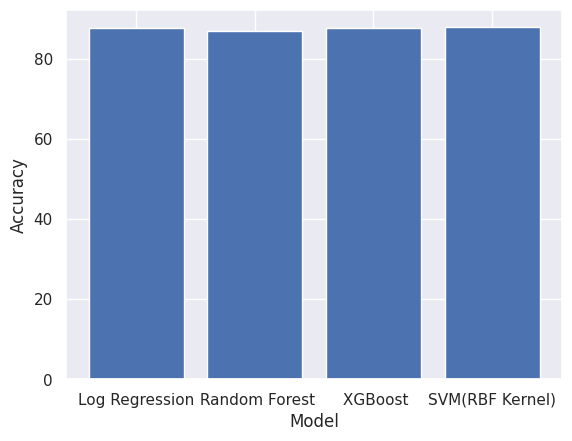

In [ ]:
# Before applying a final train/test split, let's plot the model performances for good measure
logregPerformance = bayes_search_logreg.best_score_*100
rfPerformance = bayes_search_rf.best_score_*100
svmPerformance = bayes_search_sv.best_score_*100
xgbPerformance = bayes_search_xgb.best_score_*100

models = ['Log Regression', ' Random Forest', ' XGBoost', 'SVM(RBF Kernel)']

scores = [rfPerformance, svmPerformance, rfPerformance, xgbPerformance]
plt.bar(models,scores)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.show()

As witnessed above, they all performed relatively similar, and this was the same case for a randomised search, and different feature engineering rounds.

The highest score obtained was 88.12% obtained by the random forest classifier with the grid search. However, none of the other models trailed too far behind.

Considering the baseline models 55% accuracy, there is certainly a case for using said models to predict credit application outcomes in the context of this dataset.

It is interesting to note, the negligible impact of various parameter optimisation techniques and different models. Despite random forest performing statistically the best, I would propose examining the ROC curve and PR curves to get a more in-depth look at each models performance outside of accuracy alone

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


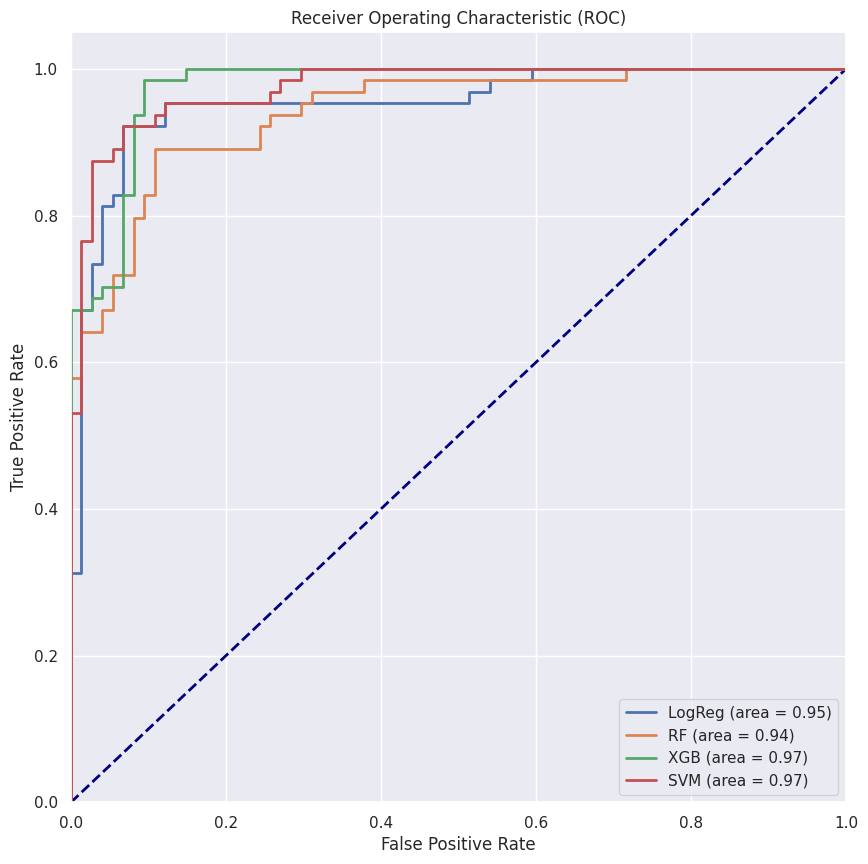

In [11]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True, random_state=1)


# Tuning models

classifiers = {
    "LogReg": LogisticRegression(
        C = 0.08858667904100823,
        max_iter = 100,
        penalty = 'l2',
        solver = 'saga'
    ),

    "RF": RandomForestClassifier(
        max_depth = 13,
        max_features = 'auto',
        min_samples_leaf = 6,
        min_samples_split = 10,  
        n_estimators = 10  
    ),

    "XGB": xgb.XGBClassifier(
        colsample_bytree = 0.8,
        gamma = 0.2,
        learning_rate = 0.1,
        max_depth = 5,
        min_child_weight = 3,
        n_estimators = 50,
        objective = 'binary:logistic',
        subsample = 0.8
    ),

    "SVM": svm.SVC(
        kernel='rbf',
        C = 100000000.0,
        gamma = 0.0001
    )
}


plt.figure(figsize=(10,10))
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')


for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    
    if hasattr(classifier, "predict_proba"):
        y_score = classifier.predict_proba(X_test)[:, 1]
    else:
        y_score = classifier.decision_function(X_test)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(1)
    plt.plot(fpr, tpr, lw=lw, label=f'{name} (area = %0.2f)' % roc_auc)
   
plt.figure(1)
plt.legend(loc="lower right")
plt.show()

Looking at the curve above, a few conclusions can be drawn:


*   All of the models have performed well, with the lowest AUC value being 0.94 which is very impressive.
*   SVM and XGB are the best performers in this context, and as such they have a high degree of seperability between the two class outcomes. Which is ideal of course.


With the parameters optimised, and the model performances clearly defined and approved, I am now going to test both an the SVM and XGBoost models with the dataset, and then pick the greater performer of the two. 






In [18]:
#XGBoost

XGB = xgb.XGBClassifier(
        colsample_bytree = 0.8,
        gamma = 0.2,
        learning_rate = 0.1,
        max_depth = 5,
        min_child_weight = 3,
        n_estimators = 50,
        objective = 'binary:logistic',
        subsample = 0.8
    )

#Fitting
XGB.fit(X_train,y_train)

#Testing
XGBPred = XGB.predict(X_test)

#Metrics
xgbAccuracy = accuracy_score(y_test, XGBPred)
xgbPrecision = precision_score(y_test, XGBPred)
xgbRecall = recall_score(y_test, XGBPred)
xgbMatrix = confusion_matrix(y_test, XGBPred)

#SVM
SVM = svm.SVC(
        kernel='rbf',
        C = 100000000.0,
        gamma = 0.0001
    )

#Fitting
SVM.fit(X_train, y_train)

#Testing
SVMPred = SVM.predict(X_test)

#Metrics
SVMAccuracy = accuracy_score(y_test, SVMPred)
SVMPrecision = precision_score(y_test, SVMPred)
SVMRecall = recall_score(y_test, SVMPred)
SVMMatrix = confusion_matrix(y_test, SVMPred)


print(f'XGB Accuracy: {xgbAccuracy:.2f}')
print(f'XGB Precision: {xgbPrecision:.2f}')
print(f'XGB Recall: {xgbRecall:.2f}')
print(f'XGB Confusion Matrix: {xgbMatrix}')

print("----------------------------------------")

print(f'SVM Accuracy: {SVMAccuracy:.2f}')
print(f'SVM Precision: {SVMPrecision:.2f}')
print(f'SVM Recall: {SVMRecall:.2f}')
print(f'SVM Confusion Matrix: {SVMMatrix}')






XGB Accuracy: 0.87
XGB Precision: 0.91
XGB Recall: 0.80
XGB Confusion Matrix: [[69  5]
 [13 51]]
----------------------------------------
SVM Accuracy: 0.92
SVM Precision: 0.91
SVM Recall: 0.92
SVM Confusion Matrix: [[68  6]
 [ 5 59]]


As witnessed in the results, the SVM was the clear winner between the two, as it outperformed XGB in accuracy and recall, whilst yielding the same precision score.

Additionally, the SVM model produced above 90% on all metrics, this is fantastic and shows that this model could be a great choice for a credit application problem.

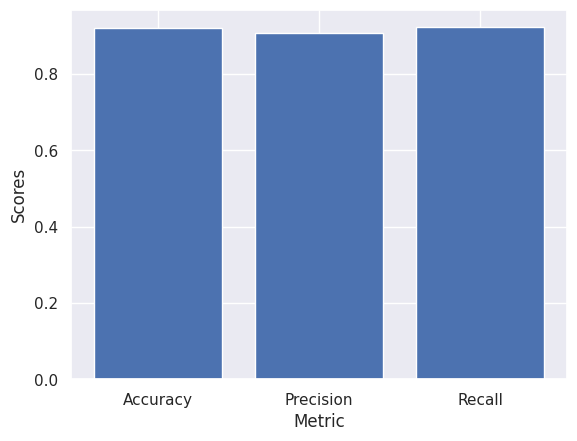

In [24]:
metrics = ['Accuracy', 'Precision', 'Recall']
values = [SVMAccuracy, SVMPrecision, SVMRecall]

plt.bar(metrics,values)
plt.xlabel("Metric")
plt.ylabel("Scores")
plt.show()